# Abordagem Inicial 

## Objetivo 

### Propor método para:
* encontrar representações comuns de diferentes modalidades sensoriais
* aumentar a quantidade de dados utilizados para redução de dimensionalidade do sinal
* melhorar a sensibilidade de análises MVPA posteriores 

### Inicialmente codificar cada instante de tempo (sem usar janelas no tempo)
### Decodificar o momento que estava na mesma e na outra modalidade a partir do estado reduzido
* Comparar com decodificação usando: (1) Sinais originais, (2) PCA geral, (3) PCA em cada ponto, (4) Auto-encoder
### Ver sobre use da auto-encoders e VAEs
### Checar sobre predição da reprodução do intervalo temporal


In [1]:
import pandas as pd

In [2]:
PATH_FOLDER = '../data/processed/' 

In [3]:
aud_1 =  pd.read_csv(PATH_FOLDER+'auditory_exposure_1.csv')
aud_2 =  pd.read_csv(PATH_FOLDER+'auditory_exposure_2.csv') 
vis_1 =  pd.read_csv(PATH_FOLDER+'visual_exposure_1.csv') 
vis_2 =  pd.read_csv(PATH_FOLDER+'visual_exposure_2.csv')

### Passo 1: treinar com dados completos capturados do experimento
* Entrada e saída como o mesmo sinal (um número para cada eletrodo)
* Usar uma rede fully connected e auto-encoder padrão
    * 64(E) - 32 - 16 - 32 - 64(S)
    * Fazer testes verificando o erro de reconstrução
* Uma rede por voluntário e por modalidade
* Pouca quantidade de dados -> incluir regularização, como dropout, para evitar overfitting


# Por voluntário

In [4]:
import sys

sys.path.append("../src/data/")
sys.path.append("../src/tools/")
sys.path.append("../src/models/")
sys.path.append("../src/external/")
sys.path.append("../src/visualization/")

In [5]:
from my_autoenconder import *

In [6]:
from file import *
from conversion import *
from exposure import _exposure_1, _exposure_2, _exposure_1_bad, _exposure_2_bad, get_group_time, fixing_bad_trials, get_last_125ms
from classification import *
from statistical_tests import *
from report import *

1 items had no tests:
    __main__
0 tests in 1 items.
0 passed and 0 failed.
Test passed.


../src/models/classification.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
from tqdm.autonotebook import tqdm
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut


In [8]:
def classification_autoEncoder(dataFrame, categoria, exposure):
    '''






    '''

    dataFrame_result = []
    history = []

    for ind, pearson in tqdm(dataFrame.groupby('people')):

        X = pearson.drop(['trial', 'group', 'people'], 1)
        y = pearson['group']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        

        train_mean = np.average(X_train, axis=0)

        X_train_without_mean = np.subtract(X_train, train_mean)
        X_test_without_mean = np.subtract(X_test, train_mean)

        X_train_without_mean = X_train_without_mean.T
        X_test_without_mean = X_test_without_mean.T

        clf = GaussianNB()

        
        clf.class_prior_ = [(1/6),(1/6),(1/6),(1/6),(1/6),(1/6)]
        
        autoEncoder_ = my_autoenconder(epochs=1000,
                                       batch_size=32,
                                       validation_size=[],
                                       random_state=42,
                                       regularizer=regularizers.l1(10e-5),
                                       exposure=exposure,
                                       modality=categoria)

        autoEncoder_.make_auto_enconder(16)

        autoEncoder_.fit(X_train_without_mean)

        X_train_auto = autoEncoder_.transform(X_train_without_mean.T)

        X_test_auto = autoEncoder_.transform(X_test_without_mean.T)


        clf = clf.fit(X_train_auto, y_train)

        y_pred = clf.predict(X_test_auto)

        for y_i_pred, y_i_test in list(zip(y_pred,y_test.values)):
            dataFrame_result.append([ind, y_i_pred,y_i_test, categoria, exposure])

            
    return dataFrame_result, autoEncoder_.history

In [9]:
import matplotlib.pyplot as plt

    
def plot_history(history):

    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [10]:
resu_aud_1, history_aud_1 = classification_autoEncoder(aud_1,'Auditory','E1')


In [11]:
resu_aud_2, history_aud_2 = classification_autoEncoder(aud_2,'Auditory','E2')


In [12]:
resu_vis_1, history_vis_1 = classification_autoEncoder(vis_1,'Visual','E1')


In [13]:
resu_vis_2, history_vis_2 = classification_autoEncoder(vis_2,'Visual','E2')


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


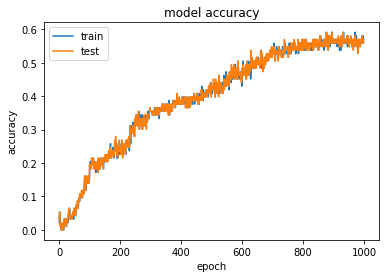

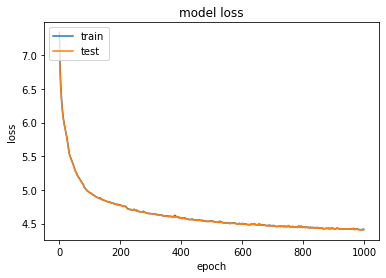

In [14]:
plot_history(history_aud_1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


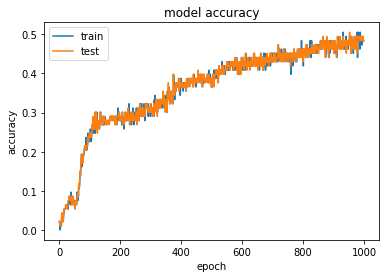

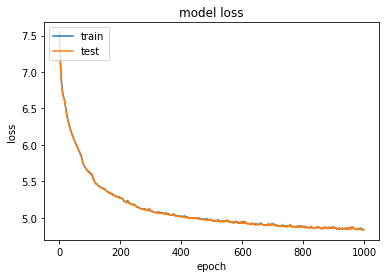

In [15]:
plot_history(history_aud_2)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


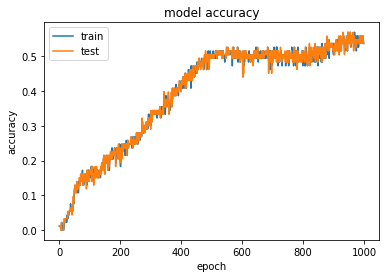

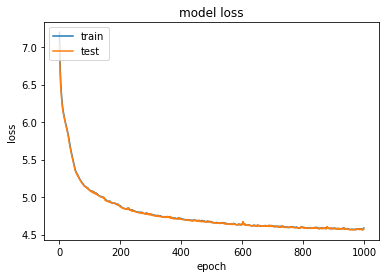

In [16]:
plot_history(history_vis_1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


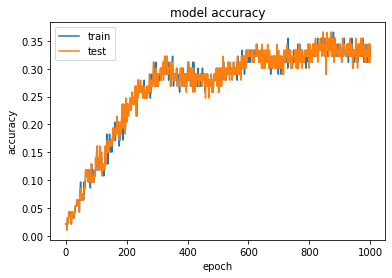

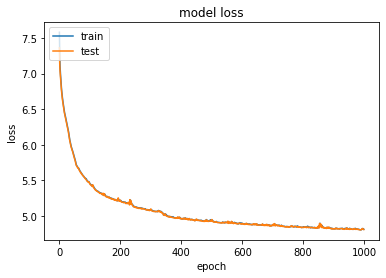

In [17]:
plot_history(history_vis_2)

In [18]:
merge_autoenco, merge_autoenco_mode = merge_export(resu_aud_1, resu_aud_2,
                                                   resu_vis_1, resu_vis_2,
                                                   '../data/processed/auto_enconder_1.csv')

In [19]:
ck_auto = cohen_kappa(merge_autoenco, plot_option=False, title='')

In [20]:
print_classification_by_mod(merge_autoenco)

##################################################
Classificação nos Dados Visual, exposição 1
              precision    recall  f1-score   support

           1       0.18      0.19      0.18        90
           2       0.20      0.22      0.21        72
           3       0.24      0.21      0.22        78
           4       0.10      0.10      0.10        69
           5       0.18      0.11      0.13       101
           6       0.16      0.27      0.20        51

    accuracy                           0.18       461
   macro avg       0.18      0.18      0.18       461
weighted avg       0.18      0.18      0.17       461

##################################################
Classificação nos Dados Visual, exposição 2
              precision    recall  f1-score   support

           1       0.39      0.22      0.28       141
           2       0.19      0.20      0.19        74
           3       0.26      0.18      0.21        88
           4       0.12      0.17      0.15       

In [21]:
t_test(ck_auto)

../src/visualization/statistical_tests.py:54: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  'p-value': lambda x: stats.ttest_1samp(x, 0)[1]})


Stats   p-value
Exposures Modality                    
E1        Auditory  1.057413  0.303583
          Visual    3.030217  0.006885
E2        Auditory  1.482861  0.154509
          Visual    1.821508  0.084313

In [ ]:
plot_history

### Passo 2: gerar uma representação comum entre ambas as modalidades
* Treinar com a mesma rede para visual e auditivo
* Objetivo é verificar se gera uma melhor representação comum entre as modalidades
* Comparar o desempenho com a rede treinada em apenas uma modalidade
* Treinar redes separadas para visual e auditivo, compartilhando a parte da codificação
* Treinamento com exemplos de ambas as modalidades
* Pode ser mais interessante, pois enfatiza uma codificação comum, mas permite diferenciações na decodificação




### Passo 3: obter representações comuns entre sujeitos
* Treinar a mesma rede para todos os participantes 
* Objetivo é gerar as codificações a partir de grandes quantidades de dados
* Abordagem 1: Fazer para a rede uma rede codificação/decodificação comum a todos
    * Depois pode ser afinada para cada participante individualmente
* Abordagem 2: Usar apenas a parte de codificação em comum
    * Enfatiza uma codificação comum, mas permite diferenciações na decodificação
* Neste caso o classificador poderia ser comum também?



### Passo 4: capturar informação temporal (opcional)
* Repetir os passos anteriores, mas usando 5 valores para cada eletrodo (1 a cada 25 ms)
* Objetivo é verificar se mais detalhes temporais melhoram a representação do tempo
* Inicialmente utilizar uma arquitetura fully connected 
    * 320(E) - 160 - 80 - 40 - 80 - 160 - 320(S)
* Outra possibilidade é colocar alguma estrutura
* Transformação é inicialmente realizada sobre a série temporal de cada eletrodo
* Poderia também juntar sinais de eletrodos vizinhos
* Isso permitiria diminuir o número de conexões